In [1]:
import sys
import numpy as np
import pandas as pd

from rdkit.Chem import AllChem, Descriptors, Descriptors3D
from rdkit.Chem import FilterCatalog
from rdkit.Chem.FilterCatalog import *

In [2]:
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_A)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_B)
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_C)
catalog = FilterCatalog(params)

In [3]:
df = pd.read_csv("/path_to_file/CD8128_LC3134.csv", sep="\t").dropna(subset=["Smiles"]).reset_index(drop=True)

print("Number of molecules in total:", len(df))

Number of molecules in total: 11262


In [4]:
PAINS_clean_rows = []
PAINS_rows = []
invalid_smiles = []
total = len(df)

for i, row in df.iterrows():
    if i % 1000 == 0 and i > 0:
        print(f"{round(100 * (i / total))}% done ...")

    smiles = row["Smiles"]
    mol = AllChem.MolFromSmiles(smiles)
    
    if mol is not None:
        
        if catalog.HasMatch(mol):
            entry = catalog.GetFirstMatch(mol)
            filter_type = entry.GetProp('Scope')
            description = entry.GetDescription()

            # Add the row with filter information to the failed_rows list
            row["Filter_Type"] = filter_type
            row["Description"] = description
            PAINS_rows.append(row)

        else: 
            # If the molecule passes the filter, add the row to the valid_rows list
            PAINS_clean_rows.append(row)
       
    else:
        # Handle invalid SMILES by adding them to the invalid_smiles list
        print(f"Invalid SMILES at row {i}: {smiles}")
        invalid_smiles.append(smiles)

        
# Create a new DataFrame with only the valid rows  
PAINS_clean_df = pd.DataFrame(PAINS_clean_rows)
# Create a new DataFrame with only the failed rows and filter information     
PAINS_df = pd.DataFrame(PAINS_rows)


# Print the number of molecules that are PAINS and pass through the PAINS_filter
print("Number of molecules PAINS:", len(PAINS_df))  
print("Number of molecules pass through PAINS_filter:", len(PAINS_clean_df)) 

# Print the list of invalid SMILES strings for further investigation
print("Invalid SMILES strings:", invalid_smiles)

9% done ...
18% done ...
27% done ...
36% done ...
44% done ...
53% done ...
62% done ...
71% done ...
80% done ...
89% done ...
98% done ...
Number of molecules PAINS: 761
Number of molecules pass through PAINS_filter: 10501
Invalid SMILES strings: []


In [5]:
print(PAINS_df[:5])

                                               Smiles Label   IDNUMBER  \
17  Oc(ccc1ccccc11)c1-c(c1ccccc11)cc(/N=N/c(ccc2cc...    CD  0422-0025   
18  Cc(cc1)cc(/N=N/c(cc2)c(ccc(N(C)c3ccc(c(/N=N/c(...    CD  0422-0028   
20                  Oc(cccc1)c1/N=C/c1ccc(cccc2O)c2n1    CD  0422-0036   
21       Cc(cc1C)c(ccc(C(C(c2c3cccc2)=O)=C3O)n2)c2c1O    CD  0422-0106   
23                             C/C(/C(C)=O)=N\NC(N)=O    CD  0488-0229   

                                             CHEMNAME  \
17  3'-[(8-hydroxyquinolin-2-yl)diazenyl][1,1'-bin...   
18  2,2'-(methylazanediyl)bis{5-[(2-methoxy-5-meth...   
20    2-{[(2-hydroxyphenyl)imino]methyl}quinolin-8-ol   
21  3-hydroxy-2-(8-hydroxy-5,7-dimethylquinolin-2-...   
23    2-(3-oxobutan-2-ylidene)hydrazine-1-carboxamide   

                 Filter_Type          Description  
17  PAINS filters (family A)           azo_A(324)  
18  PAINS filters (family A)           azo_A(324)  
20  PAINS filters (family C)    imine_phenol_A(3)  
21  

In [6]:
ADME_clean_rows = []

for i, row in PAINS_clean_df.iterrows():
    if i % 1000 == 0 and i > 0:
        print(f"{round(100 * (i / total))}% done ...")
    
    
    smiles = row["Smiles"]
    mol = AllChem.MolFromSmiles(smiles)
    
    if mol is not None:
        logP = Descriptors.MolLogP(mol)
        MW = Descriptors.MolWt(mol)
        NHD = Descriptors.NumHAcceptors(mol)
        NHA = Descriptors.NumHDonors(mol)
        TPSA = Descriptors.TPSA(mol)
        RTB = Descriptors.NumRotatableBonds(mol)
        Fsp3 = Descriptors.FractionCSP3(mol)
        # Define multiple criteria using logical operators
        criteria_met = (
            -1 <= logP <= 4 and
            200 <= MW <= 450 and
            0 <= NHD <= 5 and  
            2 <= NHA <= 10 and
            25 <= TPSA <= 140 and
            1 <= RTB <= 9 and
            0.2 <= Fsp3 <= 0.9
        )

        if criteria_met:
            row["logP"] = logP
            row["MW"] = MW
            row["NHD"] = NHD
            row["NHA"] = NHA
            row["TPSA"] = TPSA
            row["RTB"] = RTB
            row["Fsp3"] = Fsp3
            ADME_clean_rows.append(row)
    
# Create a new DataFrame with only the valid molecules based on the criteria
ADME_clean_df = pd.DataFrame(ADME_clean_rows)

# Print the number of molecules that meet the PAINS and ADME filtering criteria 
print("Number of molecules pass through PAINS_filter:", len(PAINS_clean_df)) 
print("Number of molecules pass through ADME criteria:", len(ADME_clean_df))   

9% done ...
18% done ...
27% done ...
36% done ...
44% done ...
53% done ...
62% done ...
71% done ...
80% done ...
89% done ...
98% done ...
Number of molecules pass through PAINS_filter: 10501
Number of molecules pass through ADME criteria: 1477


In [7]:
ADME_clean_df.to_csv("/path_to_file/CD8128_LC3134_filtered.csv", index=False)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
logP_values = ADME_clean_df["logP"]
MW_values = ADME_clean_df["MW"]
NHD_values = ADME_clean_df["NHD"]
NHA_values = ADME_clean_df["NHA"]
TPSA_values = ADME_clean_df["TPSA"]
RTB_values = ADME_clean_df["RTB"]
Fsp3_values = ADME_clean_df["Fsp3"]

In [11]:
logP_bins = [-1, 0, 1, 2, 3, 4]
logP_labels = ["-1 to 0", "0 to 1", "1 to 2", "2 to 3", "3 to 4"]

MW_bins = [200, 250, 300, 350, 400, 450]
MW_labels = ["200 to 250", "250 to 300", "300 to 350", "350 to 400", "400 to 450"]

NHD_bins = [0, 1, 2, 3, 4, 5]
NHD_labels = ["0 to 1", "1 to 2", "2 to 3", "3 to 4", "4 to 5"]

NHA_bins = [2, 4, 6, 8, 10]
NHA_labels = ["2 to 4", "4 to 6", "6 to 8", "8 to 10"]

TPSA_bins = [25, 50, 75, 100, 125, 140]
TPSA_labels = ["25 to 50", "50 to 75", "75 to 100", "100 to 125", "125 to 140"]

RTB_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
RTB_labels = ["0 to 1", "1 to 2", "2 to 3", "3 to 4", "4 to 5", "5 to 6", "6 to 7", "7 to 8", "8 to 9"]

Fsp3_bins = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
Fsp3_labels = ["0.2 to 0.3", "0.3 to 0.4", "0.4 to 0.5", "0.5 to 0.6", "0.6 to 0.7", "0.7 to 0.8", "0.8 to 0.9"]

# Add more bins and labels for other properties

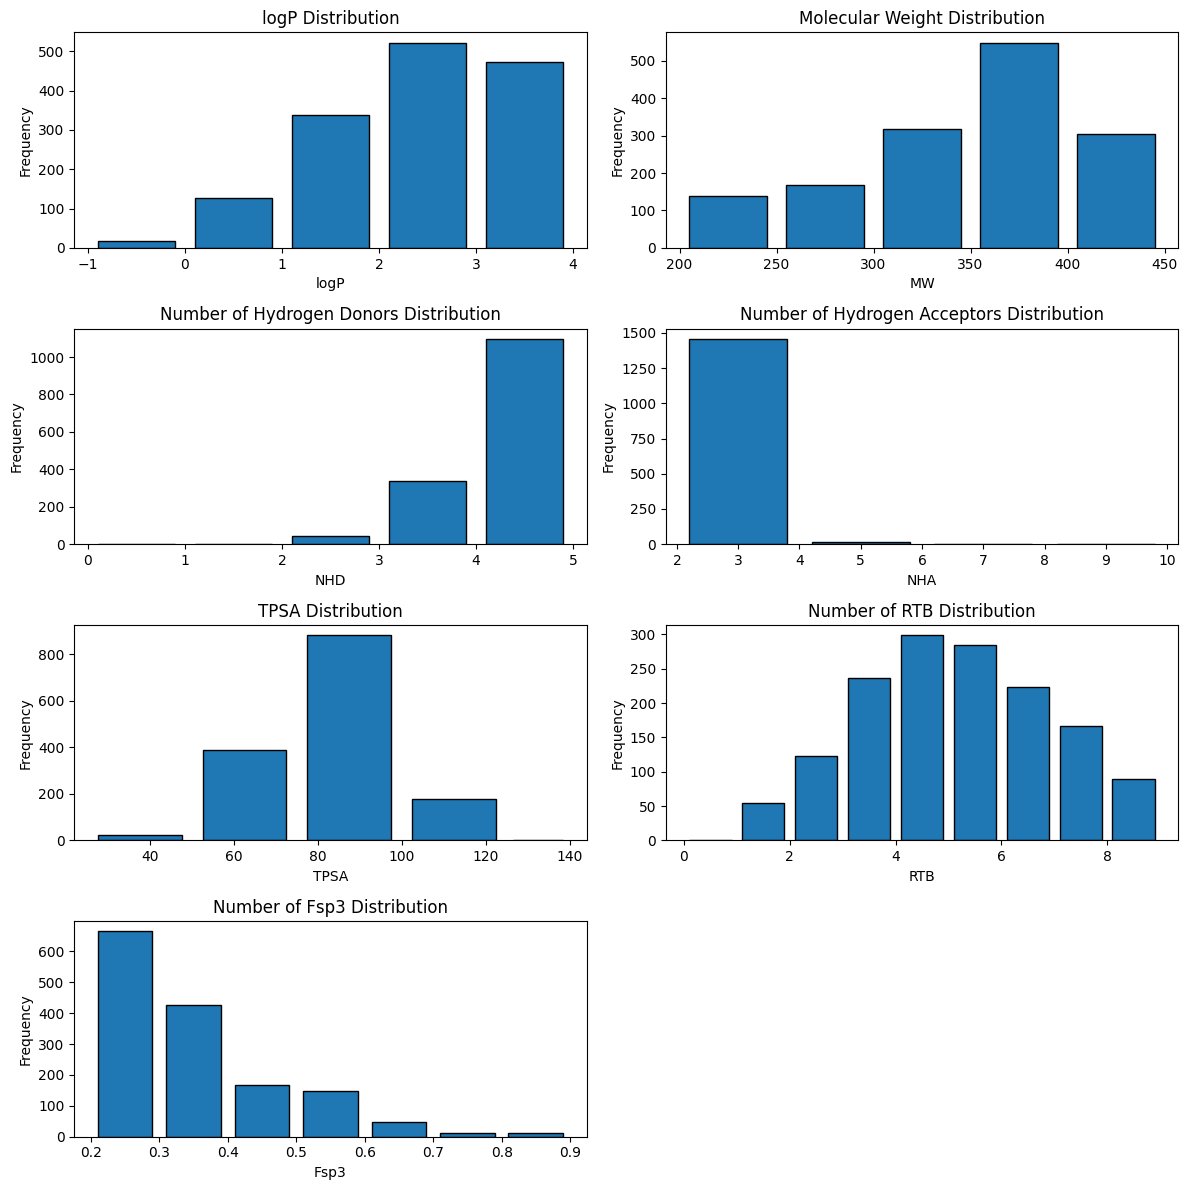

In [20]:
# Create and display histograms
plot_path = "/path_to_file/frequency&Criteria_plots.png"

plt.figure(figsize=(12, 12))

# Histogram for logP
plt.subplot(421)  # 2x2 grid, 1st plot
plt.hist(logP_values, bins=logP_bins, edgecolor='k', rwidth=0.8)
plt.title("logP Distribution")
plt.xlabel("logP")
plt.ylabel("Frequency")

# Histogram for MW
plt.subplot(422)  # 2x2 grid, 2nd plot
plt.hist(MW_values, bins=MW_bins, edgecolor='k', rwidth=0.8)
plt.title("Molecular Weight Distribution")
plt.xlabel("MW")
plt.ylabel("Frequency")

# Histogram for NHD
plt.subplot(423)  # 2x2 grid, 3rd plot
plt.hist(NHD_values, bins=NHD_bins, edgecolor='k', rwidth=0.8)
plt.title("Number of Hydrogen Donors Distribution")
plt.xlabel("NHD")
plt.ylabel("Frequency")

# Histogram for NHA
plt.subplot(424)  # 2x2 grid, 3rd plot
plt.hist(NHA_values, bins=NHA_bins, edgecolor='k', rwidth=0.8)
plt.title("Number of Hydrogen Acceptors Distribution")
plt.xlabel("NHA")
plt.ylabel("Frequency")

# Histogram for TPSA
plt.subplot(425)  # 2x2 grid, 3rd plot
plt.hist(TPSA_values, bins=TPSA_bins, edgecolor='k', rwidth=0.8)
plt.title("TPSA Distribution")
plt.xlabel("TPSA")
plt.ylabel("Frequency")

# Histogram for RTB
plt.subplot(426)  # 2x2 grid, 3rd plot
plt.hist(RTB_values, bins=RTB_bins, edgecolor='k', rwidth=0.8)
plt.title("Number of RTB Distribution")
plt.xlabel("RTB")
plt.ylabel("Frequency")


# Histogram for Fsp3
plt.subplot(427)  # 2x2 grid, 3rd plot
plt.hist(Fsp3_values, bins=Fsp3_bins, edgecolor='k', rwidth=0.8)
plt.title("Number of Fsp3 Distribution")
plt.xlabel("Fsp3")
plt.ylabel("Frequency")


plt.tight_layout()
plt.savefig(plot_path, dpi=300)